In [102]:
import pandas as pd
import numpy as np
import sklearn
import os
from datetime import datetime, timedelta
import time
import scipy
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
# import seaborn as sns
# import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
from matplotlib.ticker import FuncFormatter


In [2]:
from utils import *

### Load data

In [3]:
%%time
tx_data = pd.read_csv('data/txs_20241201_20241205.csv')

CPU times: user 4.24 s, sys: 591 ms, total: 4.83 s
Wall time: 5.13 s


In [4]:
tx_data.head()

,block_number,tx_hash,position,gas_used,tx_topology,tx_fee,burnt_fee,priority_fee,priority_fee_per_gas,__row_index
0,21303934,0xa6bceaee2ba967e5e49d9ca7c1affdb17aa4d0372620...,0,277892,Other,0.113957,0.003189,0.110768,3.985997e-07,0
1,21303934,0xdefbd4d2cff73762099b0c4e2b169d3c5294076b81fa...,1,113194,Other,0.011716,0.001299,0.010417,9.202461e-08,1
2,21303934,0x089aa1b786a539969193e2aa999986bf851214c71eae...,2,182414,Other,0.004038,0.002094,0.001945,1.065993e-08,2
3,21303934,0x447188e4f02c6ab6979c7c1cb223ec062405acba5389...,3,100946,Other,0.002216,0.001159,0.001057,1.047471e-08,3
4,21303934,0x9dbb2b931364eae0c0ed51b156c06f40558c9a7812dc...,4,142992,Other,0.002355,0.001641,0.000714,4.996008e-09,4


In [5]:
tx_data.shape

(5259656, 10)

In [6]:
tx_data.dtypes

block_number              int64
tx_hash                  object
position                  int64
gas_used                  int64
tx_topology              object
tx_fee                  float64
burnt_fee               float64
priority_fee            float64
priority_fee_per_gas    float64
__row_index               int64
dtype: object

In [7]:
tx_data.describe()

,block_number,position,gas_used,tx_fee,burnt_fee,priority_fee,priority_fee_per_gas,__row_index
count,5.259656e+06,5.259656e+06,5.259656e+06,5.259656e+06,5.259656e+06,5.259656e+06,5.259656e+06,5.259656e+06
mean,2.131857e+07,1.024422e+02,8.233416e+04,2.190576e-03,1.834902e-03,3.556732e-04,3.505407e-09,2.753854e+04
std,8.170880e+03,7.296927e+01,1.576043e+05,1.066614e-02,3.913816e-03,9.638788e-03,8.725705e-08,1.606168e+04
min,2.130393e+07,0.000000e+00,2.100000e+04,1.252671e-04,1.252671e-04,-2.775558e-17,-2.646978e-23,0.000000e+00
25%,2.131158e+07,4.600000e+01,2.100000e+04,5.175121e-04,4.730584e-04,1.913222e-05,4.377996e-10,1.369700e+04
50%,2.131857e+07,9.200000e+01,4.610900e+04,9.463658e-04,8.674566e-04,4.804247e-05,1.513872e-09,2.739400e+04
75%,2.132556e+07,1.450000e+02,1.049880e+05,2.223805e-03,1.985682e-03,1.397310e-04,2.000000e-09,4.109100e+04
max,2.133258e+07,1.088000e+03,2.436376e+07,7.732827e+00,8.361870e-01,7.724783e+00,1.036892e-04,6.308500e+04


In [8]:
block_features = build_block_features(tx_data)

In [9]:
block_features.head()

,block_number,block_gas_used,tx_count,block_gas_used_lag_1,tx_count_lag_1
0,21303934,15402273,195,NaN,NaN
1,21303935,14023233,175,15402273.0,195.0
2,21303936,19740305,219,14023233.0,175.0
3,21303937,21137059,235,19740305.0,219.0
4,21303938,10870792,131,21137059.0,235.0


### Study Priority Fee distribution with Block Position

In [10]:
start_position = 10
end_position = 150

eligible_txs = tx_data.loc[(tx_data.position >= start_position) & (tx_data.position < end_position)]

In [11]:
percentage_of_eligible_txs = len(eligible_txs) / len(tx_data) if len(tx_data) > 0 else 0

print(f'Percentage of eligible transactions: {percentage_of_eligible_txs}')
print(f"Number of eligible transactions: {len(eligible_txs)}")
print(f"Number of transactions: {len(tx_data)}")

Percentage of eligible transactions: 0.7155844412638394
Number of eligible transactions: 3763728
Number of transactions: 5259656


### Simulations

In [12]:
%%time
# Build features
# Define num lags
total_lags = 32

# With a groupby tx_topology x block_number
agg_df = build_agg_features(eligible_txs, np.arange(1, total_lags+1, 1)).merge(block_features, on='block_number')
final_df = eligible_txs.merge(agg_df, on=['block_number', 'tx_topology'])

# Without a groupby tx_topology
agg_df2 = build_agg_features2(eligible_txs, np.arange(1, 33, 1)).merge(block_features, on='block_number')
final_df2 = eligible_txs.merge(agg_df2, on=['block_number'])


CPU times: user 6.2 s, sys: 22.4 s, total: 28.6 s
Wall time: 1min 47s


In [13]:
agg_df.tx_topology.value_counts()

tx_topology
EthTransfer          28565
Other                28560
Transfer             28495
Approve              28400
SetApprovalForAll    12779
TransferFrom         12250
Withdraw             10235
TransformERC20        5561
SetSkipNFT              34
Name: count, dtype: int64

#### Quantile heuristic

In [15]:
quantile_lags = np.arange(1, 33, 1)
quantile_estimator = rolling_mean_block_pf_estimator(final_df, f"q50", quantile_lags)

In [16]:
# If this is too long, you can adjust the dataset by selecting a smaller number of blocks. Run time on my computer: 15 minutes

quantile_lags = np.arange(1, 33, 1)

q_res = []
for q in tqdm(np.arange(10, 100, 10)):
    quantile_estimator = rolling_mean_block_pf_estimator(final_df, f"q{q}", quantile_lags)
    metrics, groups = compute_metrics(quantile_estimator)
    q_res.append(metrics)

100%|██████████| 9/9 [15:31<00:00, 103.46s/it]


In [17]:
df_q = pd.DataFrame(q_res, index=[f"q{q}" for q in np.arange(10, 100, 10)])

In [18]:
df_q = df_q.rename(columns={'mae': 'MAE (Gwei)',
                     'avg_preconfirmed_errors': 'Preconfirmation Error (Gwei)',
                     'preconfirmations_eligible': '% Preconf Txs'})

df_q.drop('preconf_value', axis=1, inplace=True)

In [19]:
# Save results
formatted_df_q = df_q.round(3)
formatted_df_q.to_csv('quantile_heuristic_results.csv', sep='\t')

In [20]:
df_q

,MAE (Gwei),Preconfirmation Error (Gwei),% Preconf Txs
q10,0.489609,1.859383,81.656921
q20,0.538576,1.612926,77.233397
q30,0.494581,1.372313,70.724201
q40,0.420479,1.183946,62.450675
q50,0.402249,1.049135,48.527613
q60,0.465033,0.944804,38.022172
q70,0.569948,0.845781,29.290413
q80,0.884522,0.741086,18.139975
q90,1.762981,0.584265,10.536024


#### Linear Regression

In [21]:
# Set training threshold (train on half and test on half)
training_threshold = 21331500

In [22]:
# LR results for each quantile target

lags = np.arange(1, 6, 1)

lr_res = []
lr_train_res = []
lr_res_group = []

for q in tqdm(np.arange(10, 100, 10)):
    features = ['block_number', 'block_gas_used_lag_1'] + [f'q{q}_priority_fee_per_gas_lag_{lag}' for lag in lags]
    lr_results, lr_results_train, lr_models = train_linear_regression_one_hot(agg_df, features, training_threshold, target=f'q{q}_priority_fee_per_gas')
    lr_estimator = final_df[['block_number', 'tx_topology', 'gas_used', 'priority_fee_per_gas']].merge(lr_results, on=['block_number', 'tx_topology'])
    lr_metrics, lr_metrics_group = compute_metrics(lr_estimator)
    
    lr_res.append(lr_metrics)
    lr_train_res.append({'r2': r2_score(lr_results_train['y_true'], lr_results_train['y_pred']),
                         'mae': mean_absolute_error(lr_results_train['y_true'], lr_results_train['y_pred'])
                         })
    lr_res_group.append(lr_metrics_group)

df_lr = pd.DataFrame(lr_res, index=[f"q{q}" for q in np.arange(10, 100, 10)])

100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


In [23]:
df_lr = df_lr.rename(columns={'mae': 'MAE (Gwei)',
                     'avg_preconfirmed_errors': 'Preconfirmation Error (Gwei)',
                     'preconfirmations_eligible': '% Preconf Txs'})

df_lr.drop('preconf_value', axis=1, inplace=True)

In [24]:
# Save results
formatted_df_lr = df_lr.round(3)
formatted_df_lr.to_csv('linear_regression_results.csv', sep='\t')

In [25]:
df_lr

,MAE (Gwei),Preconfirmation Error (Gwei),% Preconf Txs
q10,0.549501,1.994292,82.604035
q20,0.566750,1.717423,73.995838
q30,0.535656,1.468480,67.632258
q40,0.448630,1.273439,59.692922
q50,0.421683,1.136605,42.562832
q60,0.530565,1.036248,29.828713
q70,0.716618,0.942171,23.259116
q80,1.206510,0.814644,16.599038
q90,2.196788,0.598727,11.026817


#### Random Forest

In [29]:
def create_rolling_features(data, rolling_windows, features):
    df = data.set_index('block_number')[features].copy()
    output = [data.set_index('block_number')]
    
    for rolling_window in tqdm(rolling_windows):
        mean_df = df.shift(1).rolling(rolling_window).mean().rename(columns={f: f + f'_mean_{rolling_window}' for f in features})
        std_df = df.shift(1).rolling(rolling_window).std().rename(columns={f: f + f'_std_{rolling_window}' for f in features})
        output.append(mean_df)
        output.append(std_df)
    
    output = pd.concat(output, axis=1)
    return output.dropna().reset_index()


In [30]:
# Preprocessing for RF

feats = [
                    'mean_priority_fee_per_gas',
                    'min_priority_fee_per_gas',
                    'skew_priority_fee_per_gas',
                    'max_priority_fee_per_gas',
                    'block_gas_used',
                    'tx_count',
                    'tx_count_lag_1',
                    'block_gas_used_lag_1'
                    ]+[f'q{q}_priority_fee_per_gas' for q in np.arange(10, 100, 10)] + [f'q{q}_priority_fee_per_gas_lag_1' for q in np.arange(10, 100, 10)]

rf_inp = agg_df2[['block_number'] + feats].copy()

windows = [5, 10, 15]

rf_inp_lags = create_rolling_features(rf_inp, windows, feats)
rf_inp_lags["mean_priority_fee_per_gas_lag_1"] = rf_inp_lags["mean_priority_fee_per_gas"].shift(1)
rf_inp_lags["skew_priority_fee_per_gas_lag_1"] = rf_inp_lags["skew_priority_fee_per_gas"].shift(1)

100%|██████████| 3/3 [00:00<00:00, 44.89it/s]


In [57]:
rf_inp_lags = create_rolling_features(rf_inp, 32, features_rf)

In [31]:
rf_inp_lags.head()

,block_number,mean_priority_fee_per_gas,min_priority_fee_per_gas,skew_priority_fee_per_gas,max_priority_fee_per_gas,block_gas_used,tx_count,tx_count_lag_1,block_gas_used_lag_1,q10_priority_fee_per_gas,...,q20_priority_fee_per_gas_lag_1_std_15,q30_priority_fee_per_gas_lag_1_std_15,q40_priority_fee_per_gas_lag_1_std_15,q50_priority_fee_per_gas_lag_1_std_15,q60_priority_fee_per_gas_lag_1_std_15,q70_priority_fee_per_gas_lag_1_std_15,q80_priority_fee_per_gas_lag_1_std_15,q90_priority_fee_per_gas_lag_1_std_15,mean_priority_fee_per_gas_lag_1,skew_priority_fee_per_gas_lag_1
0,21303950,2.021055e-09,-1.654361e-24,2.143787,7.758251e-09,26032640,285,137.0,7673181.0,8.420144e-10,...,3.941591e-10,3.994603e-10,4.147951e-10,3.911284e-10,3.419875e-10,1.902188e-10,1.084992e-10,1.042373e-09,NaN,NaN
1,21303951,1.287774e-09,0.000000e+00,1.723763,6.632761e-09,14171648,148,285.0,26032640.0,7.900000e-11,...,3.970758e-10,3.980138e-10,4.196235e-10,4.118321e-10,3.748317e-10,1.809486e-10,1.084992e-10,1.052720e-09,2.021055e-09,2.143787
2,21303952,1.236278e-09,0.000000e+00,1.717554,6.102273e-09,11560005,124,148.0,14171648.0,7.870127e-11,...,4.298923e-10,3.941598e-10,4.253332e-10,3.955424e-10,3.679267e-10,1.672283e-10,1.082561e-10,1.081581e-09,1.287774e-09,1.723763
3,21303953,2.074968e-09,0.000000e+00,8.109650,3.210558e-08,12977551,195,124.0,11560005.0,1.105582e-09,...,4.016974e-10,4.051183e-10,4.278848e-10,4.109171e-10,3.633187e-10,1.776165e-10,1.082561e-10,1.078730e-09,1.236278e-09,1.717554
4,21303954,1.474987e-09,0.000000e+00,3.444144,1.223775e-08,14841350,186,195.0,12977551.0,7.733000e-11,...,4.233900e-10,4.057918e-10,3.988365e-10,3.975915e-10,3.567560e-10,1.843975e-10,1.082561e-10,1.097300e-09,2.074968e-09,8.109650


In [43]:
training_threshold = 21331500
window = 32

params = {
    'n_estimators': 100,
    'max_depth': 10,
}

rf_res = []
rf_train_res = []
rf_res_group = []
rf_features_importances = {}

for q in tqdm(np.arange(10, 100, 10)):
    total_rf_features = [
                    f"q{q}_priority_fee_per_gas_lag_1",
                    f"q{q}_priority_fee_per_gas_mean_5",
                    # f"q{q}_priority_fee_per_gas_mean_32",
                    # f"q{q}_priority_fee_per_gas_std_32",
                ] + [
                    f"block_gas_used_mean_5",
                    f"tx_count_lag_1",
                ] + [
                    "mean_priority_fee_per_gas_mean_5",
                    "skew_priority_fee_per_gas_mean_5",
                ]

    rf_results, rf_results_train, rf_models = train_random_forest_one_hot(rf_inp_lags.reset_index(), 
                                                                          total_rf_features,
                                                                          training_threshold,
                                                                          target=f'q{q}_priority_fee_per_gas',
                                                                          params=params,
                                                                          use_topo=False
                                                                          )
    rf_estimator = final_df2[['block_number', 'tx_topology', 'gas_used', 'priority_fee_per_gas']].merge(rf_results, on=['block_number'])
    rf_metrics, rf_metrics_group = compute_metrics(rf_estimator)
    
    feature_importances = pd.DataFrame({
        "Feature": rf_models.feature_names_in_,
        "Importance": rf_models.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    
    rf_res.append(rf_metrics)
    rf_train_res.append({
                        'r2': r2_score(rf_results_train['y_true'], rf_results_train['y_pred']),
                         'mae': mean_absolute_error(rf_results_train['y_true'], rf_results_train['y_pred'])
                         })
    rf_res_group.append(rf_metrics_group)
    rf_features_importances[str(q)] = feature_importances


df_rf = pd.DataFrame(rf_res, index=[f"q{q}" for q in np.arange(10, 100, 10)])

100%|██████████| 9/9 [00:55<00:00,  6.18s/it]


In [34]:
df_rf = df_rf.rename(columns={'mae': 'MAE (Gwei)',
                     'avg_preconfirmed_errors': 'Preconfirmation Error (Gwei)',
                     'preconfirmations_eligible': '% Preconf Txs'})

df_rf.drop('preconf_value', axis=1, inplace=True)

In [35]:
# Save results
formatted_df_rf = df_rf.round(3)
formatted_df_rf.to_csv('random_forest_results.csv', sep='\t')

In [36]:
df_rf

,MAE (Gwei),Preconfirmation Error (Gwei),% Preconf Txs
q10,0.452370,2.192063,85.262777
q20,0.485356,1.868694,80.996262
q30,0.426132,1.560816,70.170591
q40,0.319905,1.342461,65.134990
q50,0.212491,1.202398,53.805411
q60,0.234623,1.109082,38.485631
q70,0.419422,1.010816,27.952978
q80,0.819866,0.850254,18.989817
q90,1.674852,0.602791,10.822191


### Model Insights

In [37]:
lr_train_res = pd.DataFrame(lr_train_res, index=[f"q{q}" for q in np.arange(10, 100, 10)]).rename(columns={'mae': 'mae_lr_train',
                                                                                                           'r2': 'r2_lr_train'})
rf_train_res = pd.DataFrame(rf_train_res, index=[f"q{q}" for q in np.arange(10, 100, 10)]).rename(columns={'mae': 'mae_rf_train',
                                                                                                           'r2': 'r2_rf_train'})

train_res = pd.concat([lr_train_res, rf_train_res], axis=1)

In [38]:
train_res['mae_lr_train'] = train_res['mae_lr_train'] * 1e9
train_res['mae_rf_train'] = train_res['mae_rf_train'] * 1e9

In [39]:
train_results = train_res.join(df_rf[['MAE (Gwei)']].rename(columns={'MAE (Gwei)': 'mae_rf'})).join(df_lr[['MAE (Gwei)']].rename(columns={'MAE (Gwei)': 'mae_lr'}))

In [41]:
train_results[['r2_lr_train', 'mae_lr_train', 'mae_lr', 'r2_rf_train', 'mae_rf_train', 'mae_rf']].round(3)

,r2_lr_train,mae_lr_train,mae_lr,r2_rf_train,mae_rf_train,mae_rf
q10,0.117,0.631,0.550,0.415,0.362,0.452
q20,0.103,0.669,0.567,0.490,0.446,0.485
q30,0.097,0.644,0.536,0.648,0.383,0.426
q40,0.098,0.607,0.449,0.738,0.281,0.320
q50,0.105,0.603,0.422,0.818,0.223,0.212
q60,0.116,0.644,0.531,0.800,0.274,0.235
q70,0.126,0.728,0.717,0.793,0.336,0.419
q80,0.147,0.960,1.207,0.814,0.483,0.820
q90,0.209,1.559,2.197,0.808,1.221,1.675


In [42]:
# MAE in Gwei
train_results[['r2_lr_train', 'mae_lr_train', 'mae_lr', 'r2_rf_train', 'mae_rf_train', 'mae_rf']].round(3).to_csv('training_results.csv', sep='\t')

#### RF feature importance

In [44]:
fi = rf_features_importances['50']

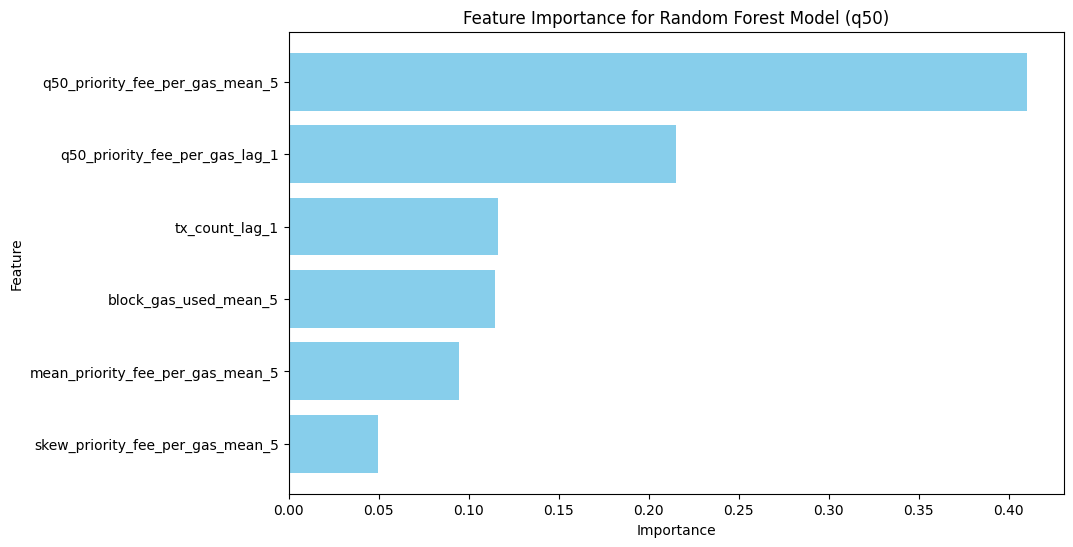

In [45]:
plt.figure(figsize=(10, 6))
plt.barh(fi['Feature'], fi['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model (q50)')
plt.gca().invert_yaxis()
plt.show()

#### Preconf error vs % preconf

/var/folders/dd/yfjv716n6r7_2w8w_lv151d80000gn/T/ipykernel_18582/264956803.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (df_q['Preconfirmation Error (Gwei)'][i], df_q['% Preconf Txs'][i]), textcoords="offset points", xytext=(0,10), ha='center')


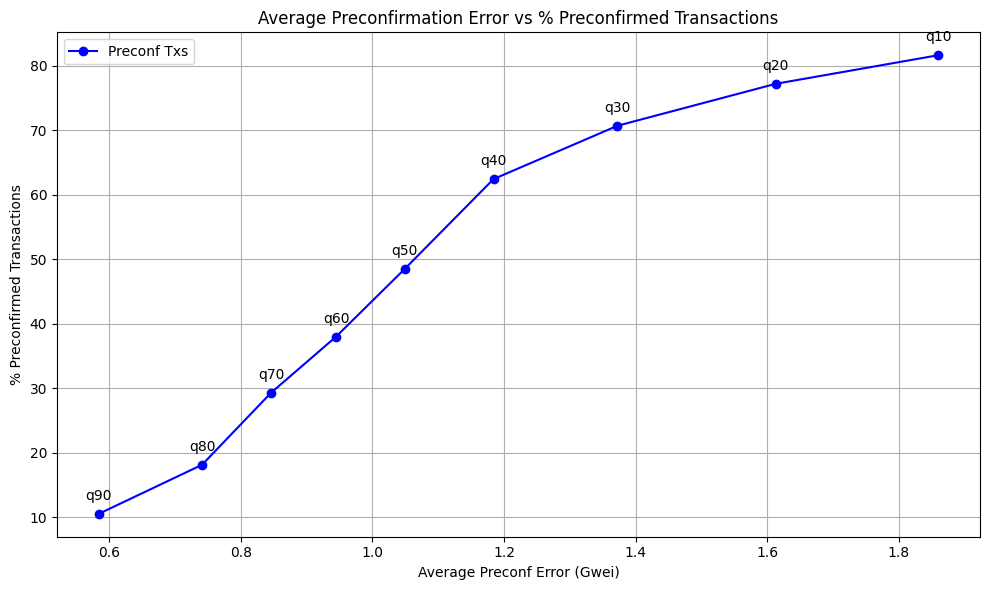

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(df_q['Preconfirmation Error (Gwei)'], df_q['% Preconf Txs'], marker='o', linestyle='-', color='b', label='Preconf Txs')

# Adding titles and labels
plt.title('Average Preconfirmation Error vs % Preconfirmed Transactions')
plt.xlabel('Average Preconf Error (Gwei)')
plt.ylabel('% Preconfirmed Transactions')
plt.grid(True)
plt.legend()

# Adding annotations for each point
for i, txt in enumerate(df_q.index):
    plt.annotate(txt, (df_q['Preconfirmation Error (Gwei)'][i], df_q['% Preconf Txs'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

## Upper bound: real quantile threshold 

In [47]:
ub_res = []
ub_res_group = []

for q in tqdm(np.arange(10, 100, 10)):
    ub_estimator = final_df[['block_number', 'tx_topology', 'gas_used', 'priority_fee_per_gas']].copy()
    ub_estimator['y_pred'] = final_df[f'q{q}_priority_fee_per_gas'].copy()
    ub_estimator['y_true'] = final_df[f'q{q}_priority_fee_per_gas'].copy()

    metrics_ub, grouped_metrics_ub = compute_metrics(ub_estimator)
    ub_res.append(metrics_ub)
    ub_res_group.append(grouped_metrics_ub)

100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


In [48]:
df_ub = pd.DataFrame(ub_res, index=[f"q{q}" for q in np.arange(10, 100, 10)])
df_ub = df_ub.rename(columns={'mae': 'MAE (Gwei)',
                     'avg_preconfirmed_errors': 'Preconfirmation Error (Gwei)',
                     'preconfirmations_eligible': '% Preconf Txs'})

df_ub.drop('preconf_value', axis=1, inplace=True)

In [49]:
df_ub

,MAE (Gwei),Preconfirmation Error (Gwei),% Preconf Txs
q10,0.0,1.813690,82.754599
q20,0.0,1.550788,71.858168
q30,0.0,1.308163,61.740806
q40,0.0,1.127561,51.557711
q50,0.0,0.994784,41.139875
q60,0.0,0.882591,32.004784
q70,0.0,0.773987,23.338376
q80,0.0,0.647561,15.882285
q90,0.0,0.453307,9.151724


In [34]:
# Save results
formatted_df_ub = df_ub.round(3)
formatted_df_ub.to_csv('upper_bound_results.csv', sep='\t')

## Metrics per tx topology

In [50]:
q = 50

features = [f'q{q}_priority_fee_per_gas_lag_{lag}' for lag in lags] + ['block_number', 'block_gas_used_lag_1', 'tx_count_lag_1', 'mean_priority_fee_per_gas', 'min_priority_fee_per_gas', 'max_priority_fee_per_gas', 'skew_priority_fee_per_gas']
rf_results, rf_results_train, rf_models = train_random_forest_one_hot(agg_df, 
                                                                        features,
                                                                        training_threshold,
                                                                        target=f'q{q}_priority_fee_per_gas',
                                                                        params=params
                                                                        )



In [51]:
# We remote setskipNFT as there are very few values
final_df = final_df.loc[final_df.tx_topology != 'SetSkipNFT']
agg_df = agg_df.loc[agg_df.tx_topology != 'SetSkipNFT']

In [ ]:
q = 50
quantile_estimator = rolling_mean_block_pf_estimator(final_df.loc[final_df.block_number > training_threshold],
                                                        f"q{q}",
                                                        quantile_lags)
global_quantile_metrics, groups_quantile_metrics = compute_metrics(quantile_estimator)
    
# LR
target = f'q{q}_priority_fee_per_gas'
total_lr_features = ['block_number', 'block_gas_used_lag_1'] + [f'q{q}_priority_fee_per_gas_lag_{lag}' for lag in lags]

lr_results, lr_results_train, lr_models = train_linear_regression_one_hot(agg_df,
                                                    total_lr_features,
                                                    training_threshold,
                                                    target=target)
    
lr_estimator = final_df[['block_number', 'tx_topology', 'gas_used', 'priority_fee_per_gas']].merge(lr_results, on=['block_number', 'tx_topology'])
global_lr_metrics, groups_lr_metrics = compute_metrics(lr_estimator)

# RF
features = [f'q{q}_priority_fee_per_gas_lag_{lag}' for lag in lags] + ['block_number', 'block_gas_used_lag_1', 'tx_count_lag_1', 'mean_priority_fee_per_gas', 'min_priority_fee_per_gas', 'max_priority_fee_per_gas', 'skew_priority_fee_per_gas']
rf_results, rf_results_train, rf_models = train_random_forest_one_hot(agg_df, 
                                                                        features,
                                                                        training_threshold,
                                                                        target=target
                                                                        )


rf_estimator = final_df[['block_number', 'tx_topology', 'gas_used', 'priority_fee_per_gas']].merge(rf_results, on=['block_number', 'tx_topology'])
global_rf_metrics, groups_rf_metrics = compute_metrics(rf_estimator)

# UB 
ub_estimator = final_df[['block_number', 'tx_topology', 'gas_used', 'priority_fee_per_gas']].copy()
ub_estimator['y_pred'] = final_df[f'q{q}_priority_fee_per_gas'].copy()
ub_estimator = ub_estimator.loc[ub_estimator.block_number > training_threshold].copy()
ub_estimator['y_true'] = final_df[f'q{q}_priority_fee_per_gas'].copy()
metrics_ub, groups_ub_metrics = compute_metrics(ub_estimator)

/Users/benoitrobaglia/Documents/ChorusOne/preconfirmations/utils.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def rolling_mean_block_pf_estimator(df, stat, lags):
/Users/benoitrobaglia/Documents/ChorusOne/preconfirmations/utils.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{stat}_pfpg_rolling_{len(lags)}'] = df[[f'{stat}_priority_fee_per_gas_lag_{l}' for l in lags]].mean(1)


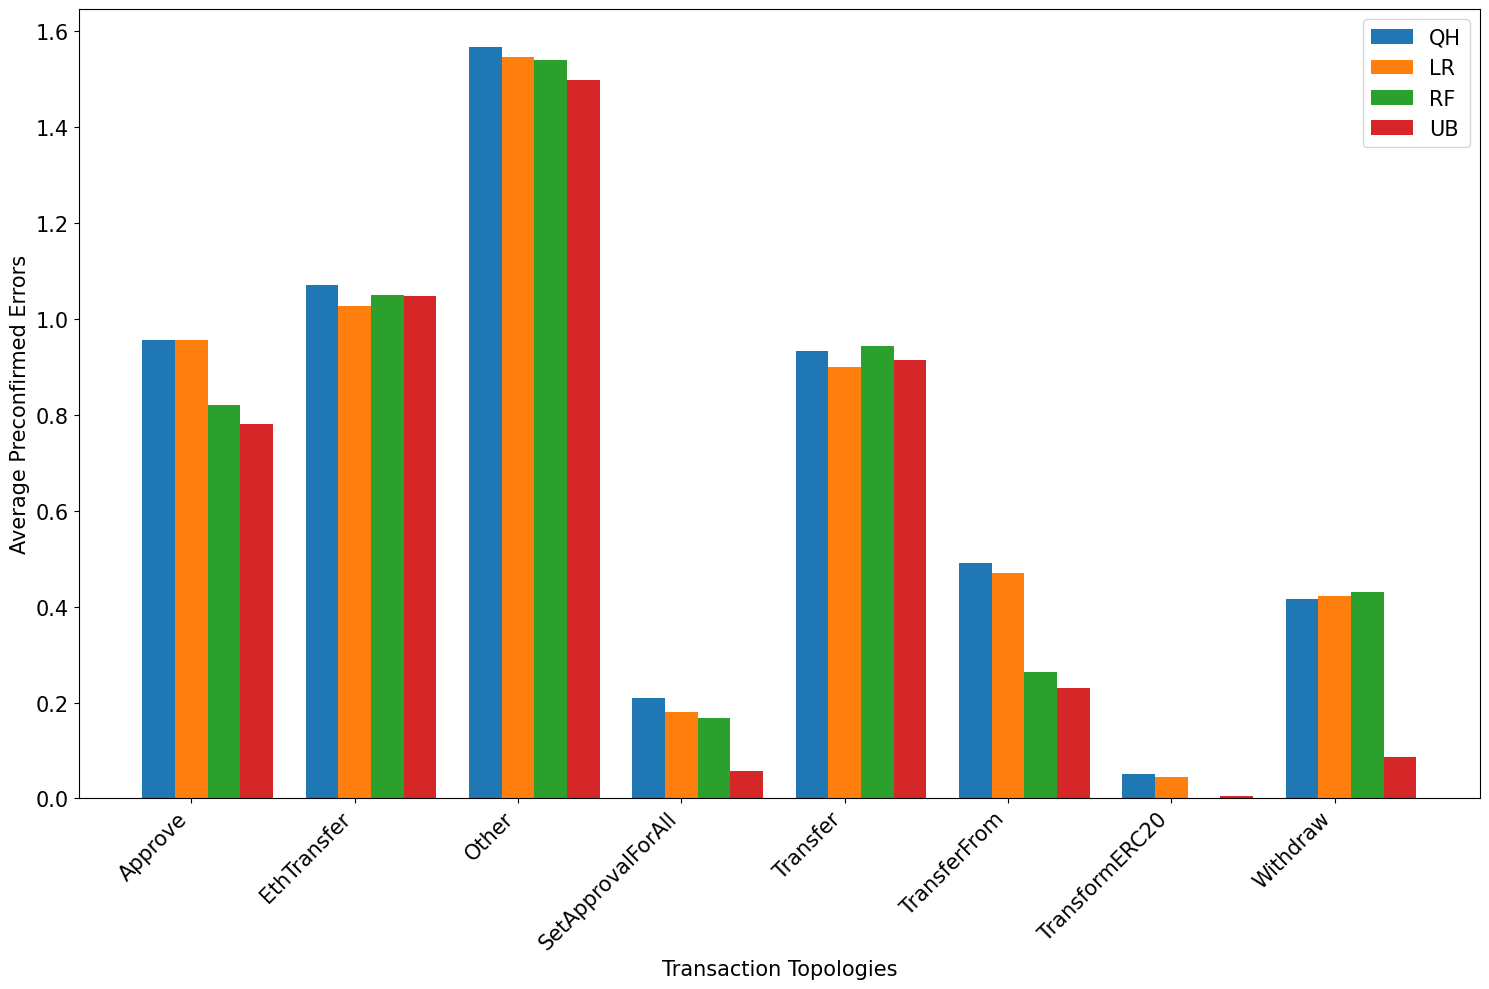

In [84]:
value_to_plot = 'avg_preconfirmed_errors'
# value_to_plot = 'preconfirmations_eligible'

tx_topologies = list(groups_quantile_metrics.keys())
q_values = [groups_quantile_metrics[tx][value_to_plot] for tx in tx_topologies]
lr_values = [groups_lr_metrics[tx][value_to_plot] for tx in tx_topologies]
ml_values = [groups_rf_metrics[tx][value_to_plot] for tx in tx_topologies]
ub_values = [groups_ub_metrics[tx][value_to_plot] for tx in tx_topologies]

# Number of topologies
n = len(tx_topologies)
x = np.arange(n)  # X-axis positions for groups
width = 0.2      # Width of each bar

# Create the bar chart
plt.figure(figsize=(15, 10))
plt.bar(x - width, q_values, width, label='QH')
plt.bar(x, lr_values, width, label='LR')
plt.bar(x + width, ml_values, width, label='RF')
plt.bar(x + 2*width, ub_values, width, label='UB')

# Add labels, title, and legend
plt.xlabel('Transaction Topologies', fontsize=15)
plt.ylabel('Average Preconfirmed Errors', fontsize=15)
# plt.ylabel('Eligible Transactions (%)', fontsize=15)
# plt.title(f'Grouped Bar Chart for {value_to_plot}')
plt.xticks(x, tx_topologies, rotation=45, ha='right', fontsize=15)  # Set x-axis tick labels
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

# Display the plot
plt.tight_layout()
plt.show()


### Preconfirmation error vs the % of preconfirmed transactions

/var/folders/dd/yfjv716n6r7_2w8w_lv151d80000gn/T/ipykernel_66572/2003409731.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



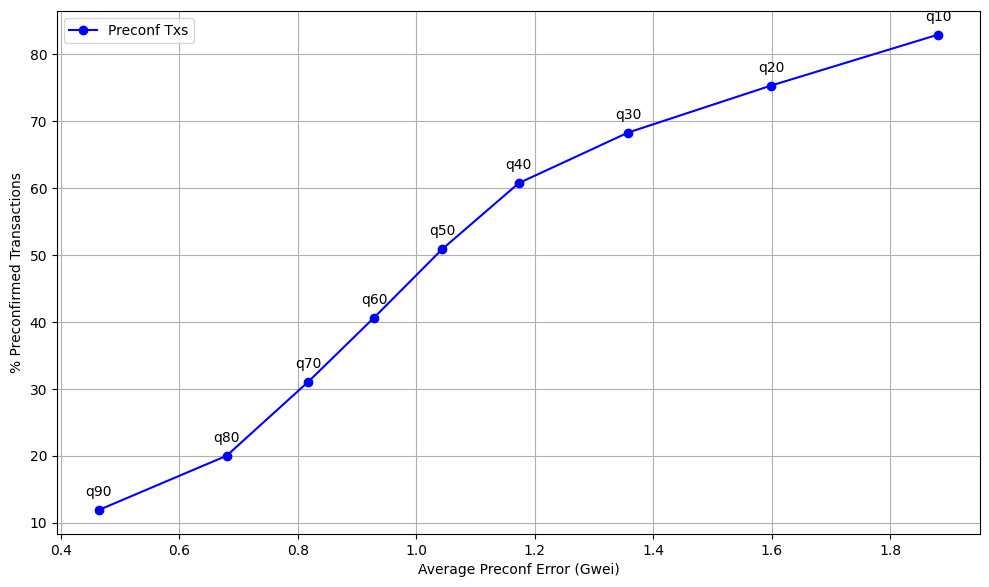

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(df_rf['Preconfirmation Error (Gwei)'], df_rf['% Preconf Txs'], marker='o', linestyle='-', color='b', label='Preconf Txs')

# Adding titles and labels
# plt.title('Average Preconfirmation Error vs % Preconfirmed Transactions')
plt.xlabel('Average Preconf Error (Gwei)')
plt.ylabel('% Preconfirmed Transactions')
plt.grid(True)
plt.legend()

# Adding annotations for each point
for i, txt in enumerate(df_rf.index):
    plt.annotate(txt, (df_rf['Preconfirmation Error (Gwei)'][i], df_rf['% Preconf Txs'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

## Rolling metrics

In [60]:
def compute_block_metrics(estimator):
    estimator['abs_error'] = np.abs(estimator['priority_fee_per_gas'] * 1e9 - estimator['y_pred'] * 1e9)
    estimator['preconf_error'] = np.clip(estimator['priority_fee_per_gas'] * 1e9 - estimator['y_pred'] * 1e9, 0, None)
    estimator['preconf_eligible'] = (estimator['priority_fee_per_gas'] > estimator['y_pred']).astype(int)
    agg_estimator = estimator.groupby('block_number').agg({
        'abs_error': 'mean',
        'preconf_error': 'mean',
        'preconf_eligible': 'mean'
    })
    return agg_estimator

In [62]:
qh_rolling = compute_block_metrics(quantile_estimator)
lr_rolling = compute_block_metrics(lr_estimator)
rf_rolling = compute_block_metrics(rf_estimator)
ub_rolling = compute_block_metrics(ub_estimator)

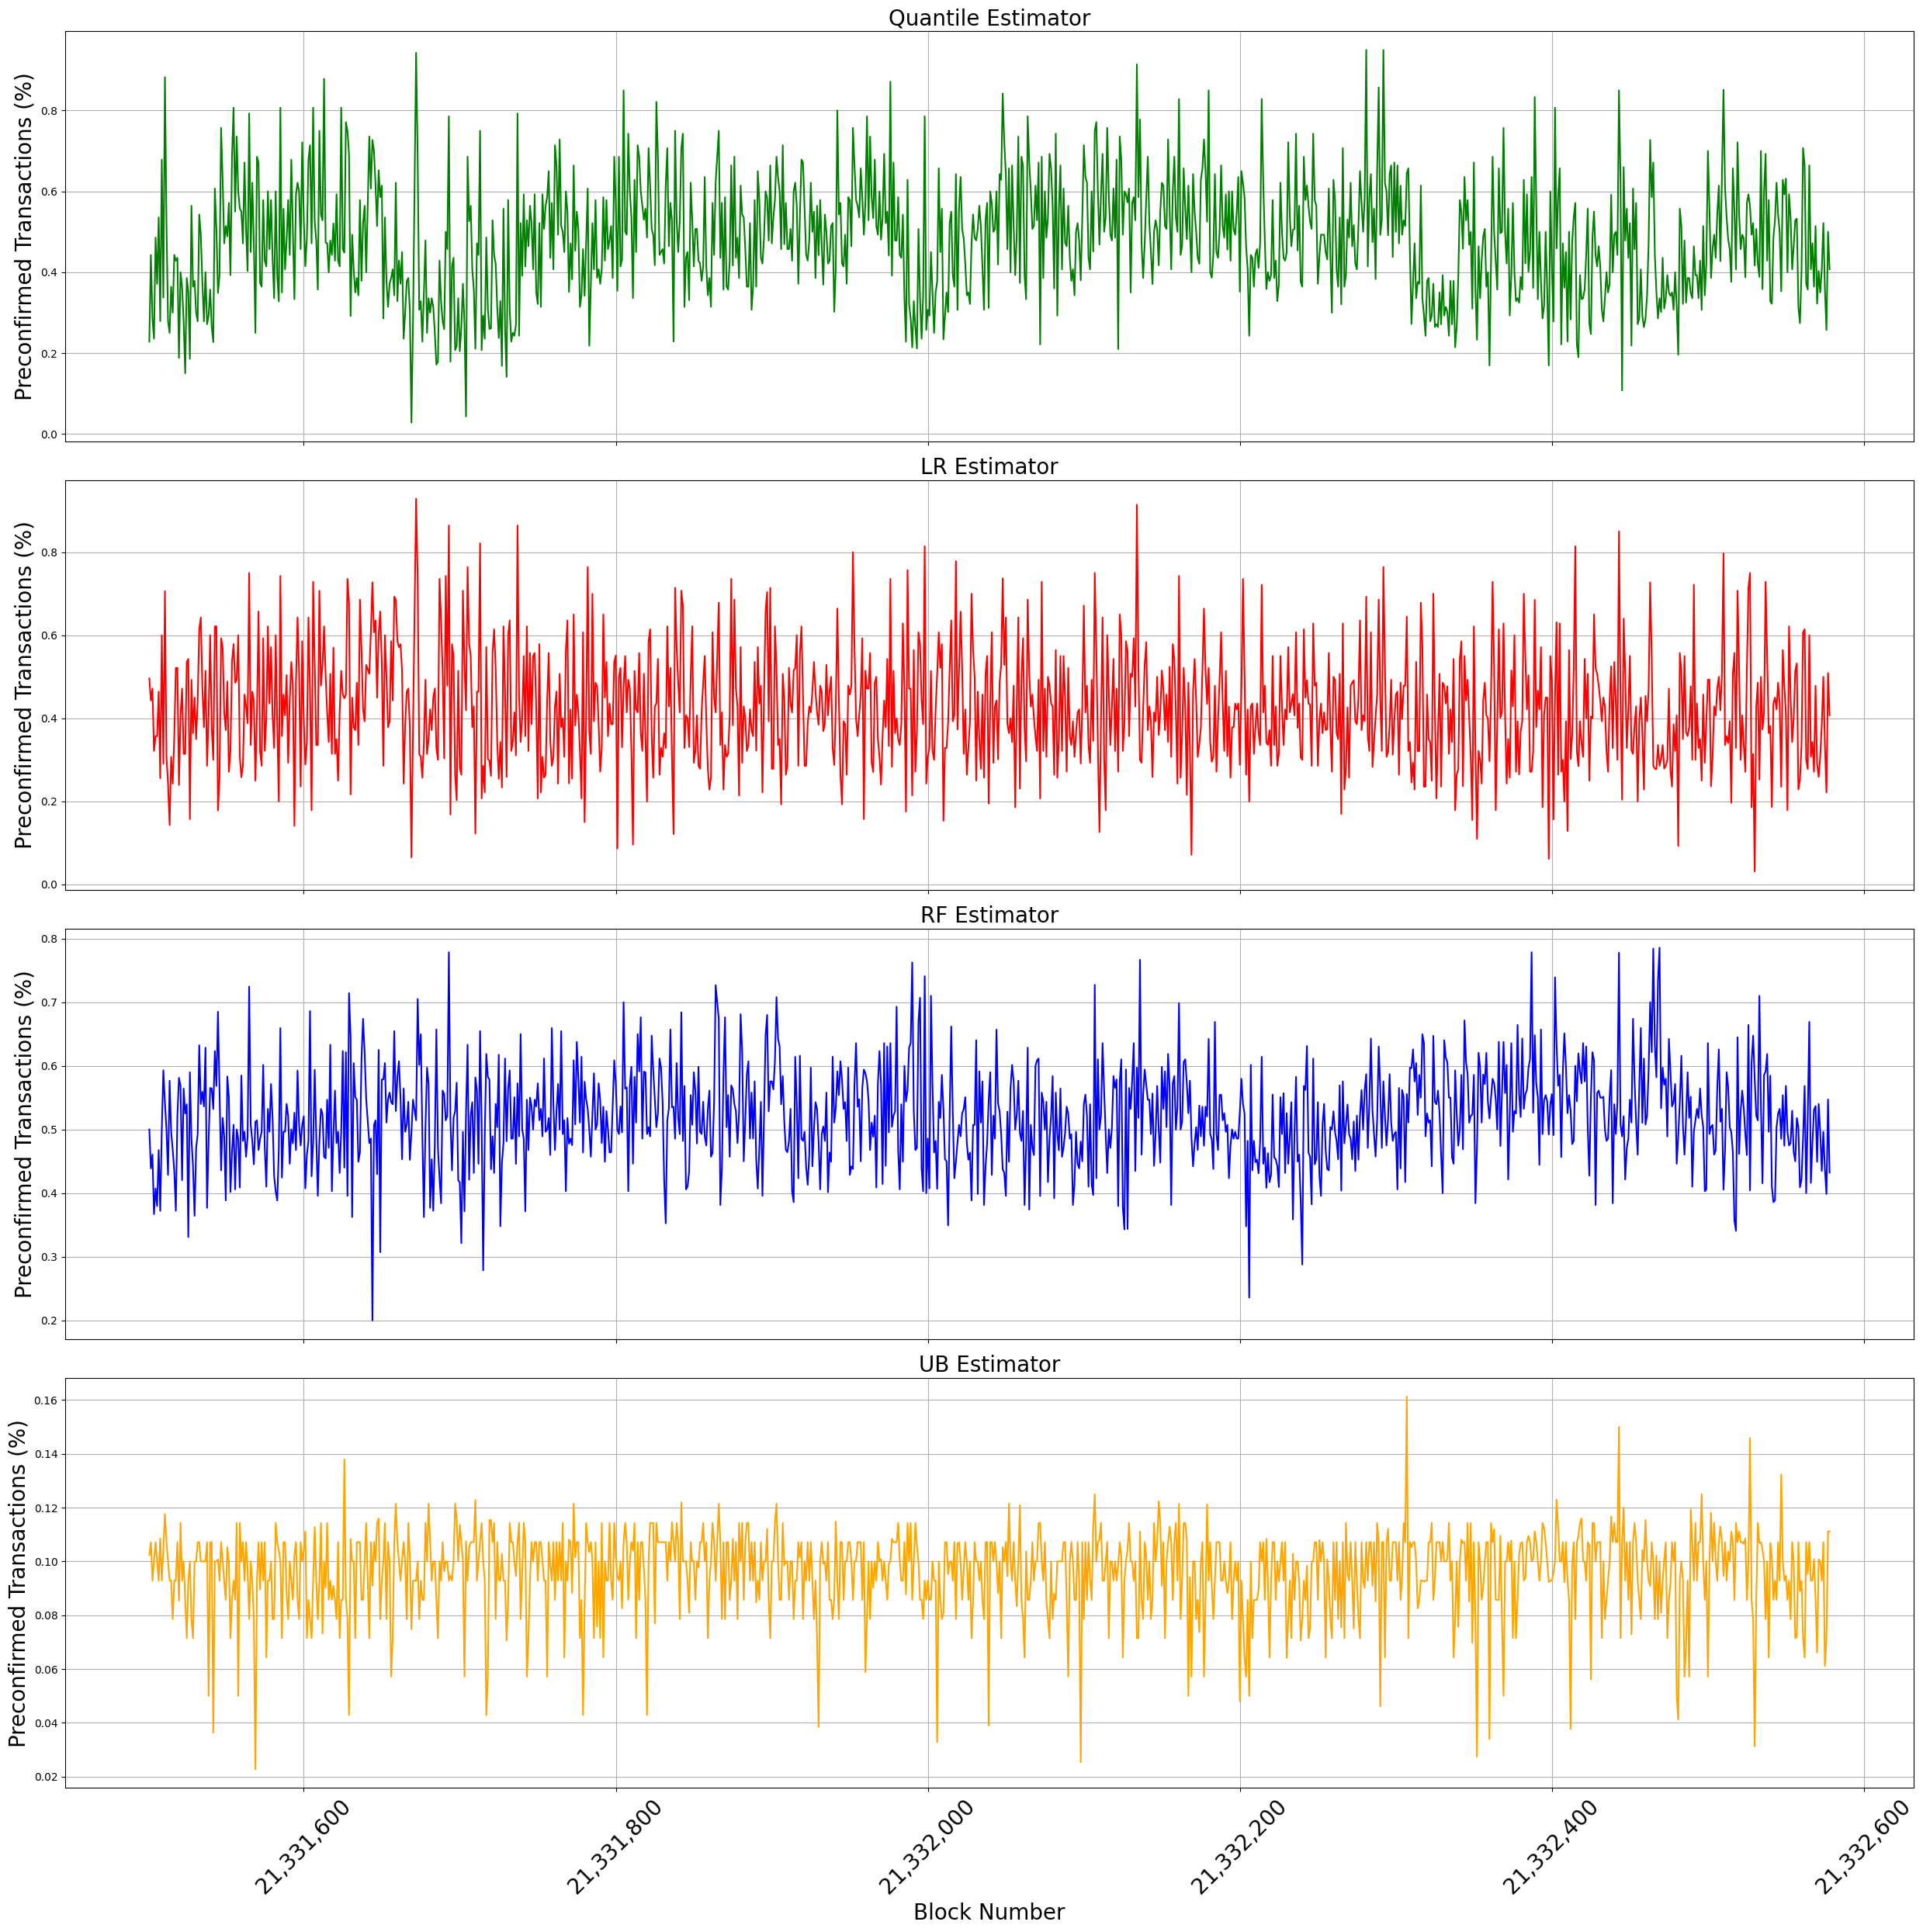

In [105]:
def format_with_commas(x, pos):
    return f'{int(x):,}'


fontsize = 20

fig, axes = plt.subplots(4, 1, figsize=(25, 25), sharex=True)

# Quantile Estimator
axes[0].plot(qh_rolling.index, qh_rolling['preconf_eligible'], color='g')
axes[0].set_title('Quantile Estimator', fontsize=fontsize)
axes[0].set_ylabel('Preconfirmed Transactions (%)', fontsize=fontsize)
axes[0].grid(True)

# LR Estimator
axes[1].plot(lr_rolling.index, lr_rolling['preconf_eligible'], color='r')
axes[1].set_title('LR Estimator', fontsize=fontsize)
axes[1].set_ylabel('Preconfirmed Transactions (%)', fontsize=fontsize)
axes[1].grid(True)

# RF Estimator
axes[2].plot(rf_rolling.index, rf_rolling['preconf_eligible'], color='b')
axes[2].set_title('RF Estimator', fontsize=fontsize)
axes[2].set_ylabel('Preconfirmed Transactions (%)', fontsize=fontsize)
axes[2].grid(True)

# UB Estimator
axes[3].plot(qh_rolling.index, ub_rolling.loc[qh_rolling.index]['preconf_eligible'], color='orange')
axes[3].set_title('UB Estimator', fontsize=fontsize)
axes[3].set_xlabel('Block Number', fontsize=fontsize)  # Only bottom subplot gets the x-axis label
axes[3].set_ylabel('Preconfirmed Transactions (%)', fontsize=fontsize)
axes[3].grid(True)


formatter = FuncFormatter(format_with_commas)
axes[3].xaxis.set_major_formatter(formatter)
axes[3].tick_params(axis='x', rotation=45, labelsize=fontsize)

# Adjust layout
plt.tight_layout()
plt.show()


In [101]:
qh_rolling.index

Index([21331501, 21331502, 21331503, 21331504, 21331505, 21331506, 21331507,
       21331508, 21331509, 21331510,
       ...
       21332569, 21332570, 21332571, 21332572, 21332573, 21332574, 21332575,
       21332576, 21332577, 21332578],
      dtype='int64', name='block_number', length=1075)

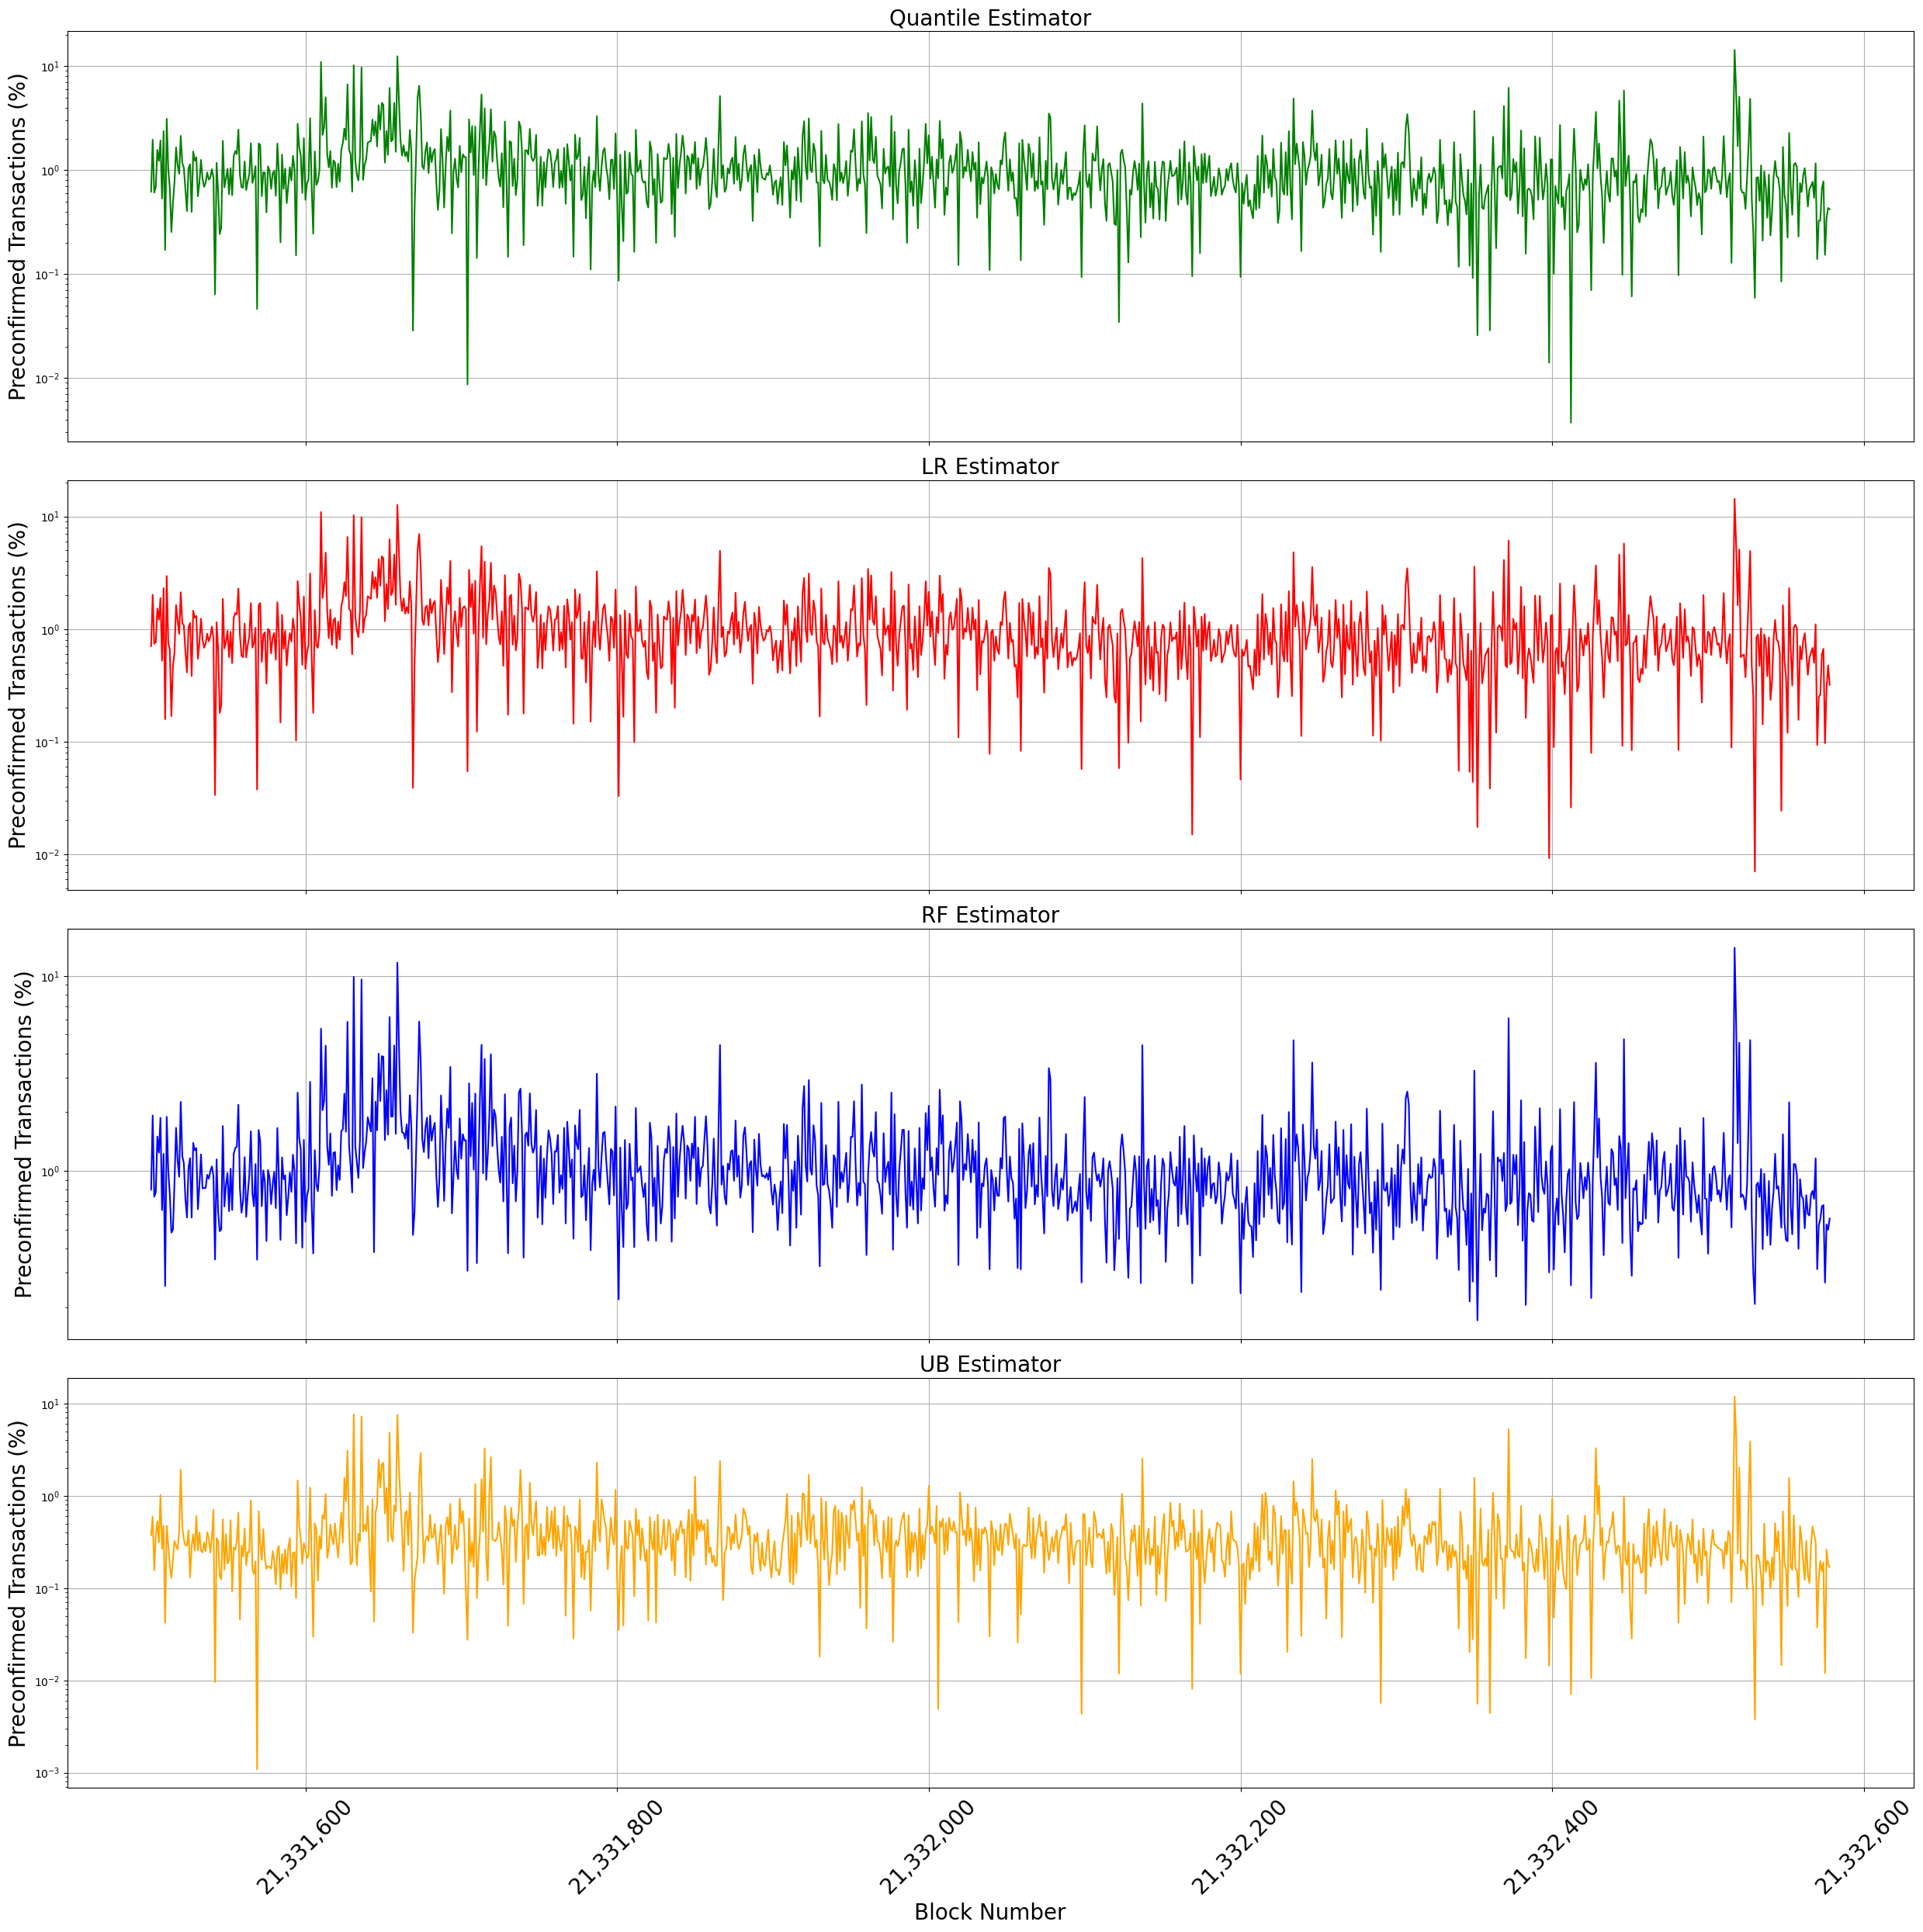

In [106]:

fig, axes = plt.subplots(4, 1, figsize=(25, 25), sharex=True)

# Quantile Estimator
axes[0].plot(qh_rolling.index, qh_rolling['preconf_error'], color='g')
axes[0].set_title('Quantile Estimator', fontsize=fontsize)
axes[0].set_ylabel('Preconfirmed Transactions (%)', fontsize=fontsize)
axes[0].set_yscale('log')
axes[0].grid(True)


# LR Estimator
axes[1].plot(lr_rolling.index, lr_rolling['preconf_error'], color='r')
axes[1].set_title('LR Estimator', fontsize=fontsize)
axes[1].set_ylabel('Preconfirmed Transactions (%)', fontsize=fontsize)
axes[1].set_yscale('log')
axes[1].grid(True)


# RF Estimator
axes[2].plot(rf_rolling.index, rf_rolling['preconf_error'], color='b')
axes[2].set_title('RF Estimator', fontsize=fontsize)
axes[2].set_ylabel('Preconfirmed Transactions (%)', fontsize=fontsize)
axes[2].set_yscale('log')
axes[2].grid(True)


# UB Estimator
axes[3].plot(qh_rolling.index, ub_rolling.loc[qh_rolling.index]['preconf_error'], color='orange')
axes[3].set_title('UB Estimator', fontsize=fontsize)
axes[3].set_xlabel('Block Number', fontsize=fontsize)  # Only bottom subplot gets the x-axis label
axes[3].set_ylabel('Preconfirmed Transactions (%)', fontsize=fontsize)
axes[3].set_yscale('log')
axes[3].grid(True)


formatter = FuncFormatter(format_with_commas)
axes[3].xaxis.set_major_formatter(formatter)
axes[3].tick_params(axis='x', rotation=45, labelsize=fontsize)


# Adjust layout
plt.tight_layout()
plt.show()


## Pre run results for lite dashboard

In [107]:
# Load small dataset
DATA_PATH = 'data/'
eligible_txs = pd.read_csv(f'{DATA_PATH}eligible_txs_sample.csv')
block_features = pd.read_csv(f'{DATA_PATH}block_features.csv')

# With a groupby tx_topology
agg_df = build_agg_features(eligible_txs, np.arange(1, 33, 1)).merge(block_features, on='block_number')
final_df = eligible_txs.merge(agg_df, on=['block_number', 'tx_topology'])

# Without a groupby tx_topology
agg_df2 = build_agg_features2(eligible_txs, np.arange(1, 33, 1)).merge(block_features, on='block_number')
final_df2 = eligible_txs.merge(agg_df2, on=['block_number'])


In [4]:
# QH

quantile_values = np.arange(10, 100, 10)
quantile_lag_values = [10, 20, 32]
training_threshold_values = [21331500, 21332079]

for q in quantile_values:
    print(f"Running for q{q}")
    for max_lag in tqdm(quantile_lag_values):
        quantile_lags = np.arange(1, max_lag+1, 1)
        for training_threshold in training_threshold_values:
            quantile_estimator = rolling_mean_block_pf_estimator(final_df.loc[final_df.block_number > training_threshold].copy(),
                                                                 f"q{q}", 
                                                                 quantile_lags)
            metrics, groups = compute_metrics(quantile_estimator)
            pointer = f"{q}_{max_lag}_{training_threshold}.p"
            pickle.dump(metrics, open(f'precomputed_results/qh/global_qh_metrics/{pointer}', 'wb'))
            pickle.dump(groups, open(f'precomputed_results/qh/groups_qh_metrics/{pointer}', 'wb'))


Running for q10


100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Running for q20


100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


Running for q30


100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


Running for q40


100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


Running for q50


100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


Running for q60


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Running for q70


100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


Running for q80


100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


Running for q90


100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


In [27]:
# LR
quantile_values = np.arange(10, 100, 10)
lr_lags_values = [5, 10, 15, 32]
lr_features = ['block_gas_used_lag_1']
training_threshold_values = [21331500, 21332079]

for q in quantile_values:
    print(f"Running for q{q}")
    target = f'q{q}_priority_fee_per_gas'
    for lr_lags in tqdm(lr_lags_values):
        target_lr_features = build_lag_features(target, np.arange(1, lr_lags+1))
        total_lr_features = target_lr_features + lr_features
        for training_threshold in training_threshold_values:                    
            lr_results, lr_results_train, lr_models = train_linear_regression_one_hot(agg_df,
                                                            total_lr_features,
                                                            training_threshold,
                                                            target=target)
        
            lr_estimator = final_df[['block_number', 'tx_topology', 'gas_used', 'priority_fee_per_gas']].merge(lr_results, on=['block_number', 'tx_topology'])
            global_lr_metrics, groups_lr_metrics = compute_metrics(lr_estimator)

            lr_pointer = f"{q}_{lr_lags}_{training_threshold}.p"
            pickle.dump(global_lr_metrics, open(f'precomputed_results/lr/global_lr_metrics/{lr_pointer}', 'wb'))
            pickle.dump(groups_lr_metrics, open(f'precomputed_results/lr/groups_lr_metrics/{lr_pointer}', 'wb'))
            pickle.dump(lr_results_train, open(f'precomputed_results/lr/lr_results_train/{lr_pointer}', 'wb'))


Running for q10


100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


Running for q20


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


Running for q30


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


Running for q40


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Running for q50


100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


Running for q60


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


Running for q70


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Running for q80


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Running for q90


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


In [108]:
# Preprocessing for RF

feats = [
                    'mean_priority_fee_per_gas',
                    'min_priority_fee_per_gas',
                    'skew_priority_fee_per_gas',
                    'max_priority_fee_per_gas',
                    'block_gas_used',
                    'tx_count',
                    'tx_count_lag_1',
                    'block_gas_used_lag_1'
                    ]+[f'q{q}_priority_fee_per_gas' for q in np.arange(10, 100, 10)] + [f'q{q}_priority_fee_per_gas_lag_1' for q in np.arange(10, 100, 10)]

rf_inp = agg_df2[['block_number'] + feats].copy()

windows = [5, 10, 15]

rf_inp_lags = create_rolling_features(rf_inp, windows, feats)
rf_inp_lags["mean_priority_fee_per_gas_lag_1"] = rf_inp_lags["mean_priority_fee_per_gas"].shift(1)
rf_inp_lags["skew_priority_fee_per_gas_lag_1"] = rf_inp_lags["skew_priority_fee_per_gas"].shift(1)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 84.82it/s]


In [109]:
# RF
quantile_values = np.arange(10, 100, 10)

training_threshold_values = [21331500, 21332079]

n_estimators_values = [100, 200, 300]
max_depth_values = [5, 10, 15, 20]

for q in quantile_values:
    print(f"Running for q{q}")
    target = f'q{q}_priority_fee_per_gas'
    total_rf_features = [
                    f"q{q}_priority_fee_per_gas_lag_1",
                    f"q{q}_priority_fee_per_gas_mean_5",
                    # f"q{q}_priority_fee_per_gas_mean_32",
                    # f"q{q}_priority_fee_per_gas_std_32",
                ] + [
                    f"block_gas_used_mean_5",
                    f"tx_count_lag_1",
                ] + [
                    "mean_priority_fee_per_gas_mean_5",
                    "skew_priority_fee_per_gas_mean_5",
                ]


    for training_threshold in training_threshold_values:
        for n_estimators in n_estimators_values:
            for max_depth in max_depth_values:
                params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                }                    
                rf_results, rf_results_train, rf_models = train_random_forest_one_hot(rf_inp_lags.reset_index(),
                                                    total_rf_features,
                                                    training_threshold,
                                                    target=target,
                                                    params=params,
                                                    use_topo=False
                                                    )

    
                rf_estimator = final_df2[['block_number', 'tx_topology', 'gas_used', 'priority_fee_per_gas']].merge(rf_results, on=['block_number'])
                global_rf_metrics, groups_rf_metrics = compute_metrics(rf_estimator)

                rf_pointer = f"{q}_{training_threshold}_{n_estimators}_{max_depth}.p"
                pickle.dump(global_rf_metrics, open(f'precomputed_results/rf/global_rf_metrics/{rf_pointer}', 'wb'))
                pickle.dump(groups_rf_metrics, open(f'precomputed_results/rf/groups_rf_metrics/{rf_pointer}', 'wb'))
                pickle.dump(rf_results_train, open(f'precomputed_results/rf/rf_results_train/{rf_pointer}', 'wb'))
                pickle.dump(rf_models, open(f'precomputed_results/rf/rf_models/{rf_pointer}', 'wb'))



Running for q10
Running for q20
Running for q30
Running for q40
Running for q50
Running for q60
Running for q70
Running for q80
Running for q90


In [69]:
# UB 

for q in tqdm(np.arange(10, 100, 10)):
    ub_estimator = final_df[['block_number', 'tx_topology', 'gas_used', 'priority_fee_per_gas']].copy()
    ub_estimator['y_pred'] = final_df[f'q{q}_priority_fee_per_gas'].copy()
    ub_estimator['y_true'] = final_df[f'q{q}_priority_fee_per_gas'].copy()

    metrics_ub, grouped_metrics_ub = compute_metrics(ub_estimator)
    pointer = f"{q}.p"
    pickle.dump(metrics_ub, open(f'precomputed_results/ub/global_ub_metrics/{pointer}', 'wb'))
    pickle.dump(grouped_metrics_ub, open(f'precomputed_results/ub/groups_ub_metrics/{pointer}', 'wb'))

100%|██████████| 9/9 [00:04<00:00,  2.11it/s]


In [25]:
# Specify the folder path
folder_path = 'precomputed_results/lr/global_lr_metrics/'

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    # Check if it's a file (not a folder)
    if os.path.isfile(file_path):
        os.remove(file_path)  # Delete the file

print("All files in the folder have been deleted.")


All files in the folder have been deleted.
